In [1]:
import cv2
from matplotlib import pyplot as plt


# Usando dlib

Dlib é un framework en C++ para IA que inclue ferramentas para a detección e identificación de caras

In [1]:
image = cv2.imread("imaxes/isaac.jpg")
imaxe_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(imaxe_color)
plt.title('Imaxe1')
plt.show()


NameError: name 'cv2' is not defined

Para traballar co detector de caras é preciso descargar:
- Un sistema para predecir a forma e posición da cara: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
- Unha RNA para identificar a a cara: http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2


# Vector Stores
Vector Stores son bases de datos explicitamente deseñadas para almacenar e recuperando vectores dun xeito eficiente. Son necesarias porque as bases de datos tradicionais non están optimizadas para almacenar e buscar grandes vectores.

OS Vector Stores poden indexar e buscar rapidamente vectores similares utilizando algoritmos de semellanza. Non é a súa función preocuparse de que farán as aplicacións cos vectores que almacena.

# Que é Chroma DB?

Chroma DB é Vector Store de código aberto utilizado para almacenar e recuperar vectores. O seu uso principal é para salvar vectores (embeddings) xunto con metadatos para ser utilizado máis tarde por LLM. 

Chroma DB características chaves:
    - Soporta distintos backends de almacenaze como DuckDB ou SQLite para standalone ou ClickHouse para sistemas máis escalables.
    - Proporciona SDKs para Python e JavaScript/TypeScript.
    - Céntrase na simplicidade, velocidade, e permitir o análise.


# Crease a instancia do cliente da base de datos

In [2]:
import chromadb
chroma_client = chromadb.Client()

ModuleNotFoundError: No module named 'chromadb'

Isto vai a crear a base de datos se non existe. Se non se lle pon parámetros, vai a xerar unha base de datos en memoria, polo que non haberá persistencia.

Se o que se desexa e persistir a base de datos:

client = chromadb.PersistentClient(path="ruta/cara/almacen")

# Colleccións

Unha collection ben a ser o equivalente a unha táboa das bases de datos relacionais, pero no contexto das bases de datos de vectores. O que se almacena nas colecciósn son vectores, cada un deles asociados a un id, que debe ser un valor único que identifique a cada vector. 

Ademais, por cada un dos vectores se pode asociar unha serie de metadatos. Estes métadatos poden servir para dous propósitos:
- Almacenar información dependente da aplicación.
- Poden ser usados nas búsquedas, reducindo o espazo de búsqueda dos vectores.



In [4]:
# collection = chroma_client.create_collection(name="caras")
# ou 

collection = chroma_client.get_or_create_collection(name="caras", metadata={"hnsw:space": "cosine"})

nCaras = collection.count()
print(f"Numero de caras previas: {nCaras}")

Numero de caras previas: 0


In [5]:
import dlib
import numpy as np

predictor_path ="./models/shape_predictor_5_face_landmarks.dat"
face_rec_model_path = "./models/dlib_face_recognition_resnet_model_v1.dat"


detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)
facerec = dlib.face_recognition_model_v1(face_rec_model_path)


Os pasos para facer unha identificación son:
- Detectar a presenza de caras, chamando a *detector*
    - detector vai devolver un array cos rectángulos onde se detectou algo
- Para cada cara detectada:
    - Predecir a forma: chamdno ao *shape_predictor*, que antes se definiu como *sp*
    - Obter a firma da cara a partires da forma: chamar face_recognition_model_v1, definido como *facerec*

A firma vai ser un vector de valores, que modeliza a cara. Para identificar unha cara haberá que ver se a distancia lineal entre o vector obtido e unha lista de vectores coñecidos previamente. Se esa distancia é inferior a 0.6 entón se pode determinar que é misma persoa.

No paso inferior rematamos con un vector que indentica a cara na variable **face_descriptor**.

In [6]:

dets = detector(imaxe_color, 1)
print("Number of faces detected: {}".format(len(dets)))
posicions = dets[0]
display(posicions)
shape = sp(imaxe_color,posicions)

face_descriptor = np.array(facerec.compute_face_descriptor(imaxe_color, shape))
display(face_descriptor)



Number of faces detected: 1


rectangle(553,143,1016,605)

array([-0.0697185 ,  0.08326543,  0.05350924, -0.05702204,  0.01707895,
       -0.04048353,  0.01171042,  0.02096582,  0.24735726, -0.0626039 ,
        0.19452217,  0.05337796, -0.23709184, -0.00746649, -0.07657124,
        0.05283979, -0.12021106, -0.11034591, -0.10487095, -0.13224068,
        0.11002182,  0.06582682, -0.02093675,  0.01883125, -0.20451719,
       -0.25701177, -0.10259065, -0.13465554, -0.02423478, -0.1872358 ,
        0.01518591,  0.00113942, -0.13626812, -0.066701  , -0.02918172,
        0.03799842, -0.00791732, -0.06753067,  0.16655503,  0.07210907,
       -0.0714143 ,  0.06717861,  0.02229135,  0.37594634,  0.17422056,
       -0.02556306,  0.00856559, -0.03801801,  0.13806969, -0.26856533,
        0.14005738,  0.10262411,  0.08596638,  0.08943693,  0.14186388,
       -0.14184001, -0.01660936,  0.15333793, -0.25113377,  0.17964791,
        0.02627639, -0.00936791, -0.09484012, -0.0160776 ,  0.13803923,
        0.16038884, -0.13320406, -0.15171154,  0.11716729, -0.18

# Engadir datos as collections

Para engadir datos hai que usar o método *add*.
- embeddings: é unha lista que conten un ou varios vectores, cada un destes últimos representado por unha lista.
- ids: unha lista co id de cada un dos vectores presente en embeddings.

Se pode engadir metadatos a cada elemento, sendo neste caso unha lista de diccionarios.

In [7]:
collection.add(
    embeddings=[list(face_descriptor)],
    metadatas = [{"nome": "Isaac"}], 
    ids = ["id1"]
)

nCaras = collection.count()
print(f"Numero de caras: {nCaras}")

Numero de caras: 1


No extracto superior almacénase **face_descriptor**, que vimos que era o vector que identificaba a cara da foto, no base de datos. Engádeselle como metadatos un diccionario onde a clave *nome* indica quen é.

# Busqueda

Para buscar dentro de base de datos se utiliza o método query, que vai a recibir unha lista de vectores a buscar e o número de resultados (vectores) a obter. Como resposta obtense un diccionario cos seguintes atributos:
- ids: lista dos id dos vectores da resposta.
- distances: lista coas distancias entre o vector identificado por ids e o vector buscado.
- metadatas: lista cos metadatos dos vectores identificado por ids

O resultado vai a estar ordeado por distancia. O vector con menor distancia vai a estar na posicion 0 das listas do resultado.

In [8]:
face_names = []

dets = detector(imaxe_color, 1)
tolerancia = 0.1
for d in dets:

    shape = sp(imaxe_color,d)
    face_descriptor = np.array(facerec.compute_face_descriptor(imaxe_color, shape))
    results = collection.query(query_embeddings=[list(face_descriptor)], 
                                n_results=5
                                )
    print(results)
    carasAtopadas = [posicion for posicion, distancia in enumerate(results['distances'][0]) if distancia < tolerancia]
    nCaras = len(carasAtopadas)
    print(f"Numero concordancias {nCaras}")
    if nCaras > 0:
        print(results['metadatas'])
        face_names.append(((d.top(), d.right(), d.bottom(), d.left()),results['metadatas'][0][0]['nome']))


Number of requested results 5 is greater than number of elements in index 1, updating n_results = 1


{'ids': [['id1']], 'distances': [[-2.384185791015625e-07]], 'metadatas': [[{'nome': 'Isaac'}]], 'embeddings': None, 'documents': [[None]], 'uris': None, 'data': None}
Numero concordancias 1
[[{'nome': 'Isaac'}]]


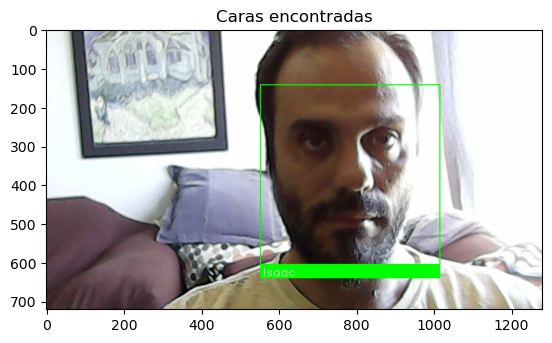

In [9]:
imaxeConMarcas = imaxe_color.copy() 
for (top, right, bottom, left), name in face_names:
    # Scale back up face locations since the frame we detected in was scaled to 1/4 size

    color = (0, 255, 0) if not name=="NonSei" else (0, 0, 255)
    # Draw a box around the face
    cv2.rectangle(imaxeConMarcas, (left, top), (right, bottom), color, 2)

    # Draw a label with a name below the face
    cv2.rectangle(imaxeConMarcas, (left, bottom + 35), (right, bottom), color, cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(imaxeConMarcas, name, (left + 6, bottom + 30), font, 1.0, (255, 255, 255), 1)

plt.imshow(imaxeConMarcas)
plt.title('Caras encontradas')
plt.show()        

In [10]:
id = 2
imaxesEscanear = (("imaxes/phill.png", "Phill"), ("imaxes/julie.jpeg", "Claire"), ("imaxes/lily.jpg", "Lily"))
for imaxeFile, nome in imaxesEscanear:
    imaxePhill = cv2.imread(imaxeFile)
    imaxePhillColor = cv2.cvtColor(imaxePhill, cv2.COLOR_BGR2RGB)

    dets = detector(imaxePhill, 1)
    print("Number of faces detected: {}".format(len(dets)))
    posicions = dets[0]
    # display(posicions)
    shape = sp(imaxePhill,posicions)

    face_descriptor = np.array(facerec.compute_face_descriptor(imaxePhill, shape))
    # display(face_descriptor)

    collection.add(
        embeddings=[list(face_descriptor)],
        metadatas = [{"nome": nome}], 
        ids = [f"id{id}"]
    )
    id = id + 1

nCaras = collection.count()

Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1


e agora collemos a foto onde están todos e se pasa o recoñecedor  de caras

In [11]:
imaxeTodos = cv2.imread("imaxes/todos.png")
imaxeTodosColor = cv2.cvtColor(imaxeTodos, cv2.COLOR_BGR2RGB)

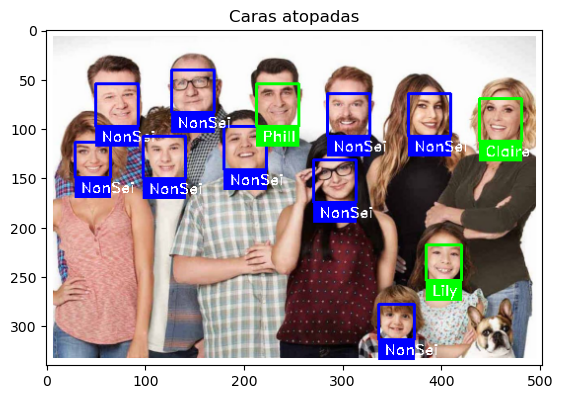

In [12]:
face_names = []

dets = detector(imaxeTodosColor, 1)
tolerancia = 0.1 # distancia máxima que permitimos entre o vector almacenado e o actual
for d in dets:

    shape = sp(imaxeTodosColor,d)
    face_descriptor = np.array(facerec.compute_face_descriptor(imaxeTodosColor, shape))
    results = collection.query(query_embeddings=[list(face_descriptor)], 
                                n_results=1
                                )
    carasAtopadas = [posicion for posicion, distancia in enumerate(results['distances'][0]) if distancia < tolerancia]
    nCaras = len(carasAtopadas)
    if nCaras == 0:
        face_names.append(((d.top(), d.right(), d.bottom(), d.left()),"NonSei"))
    else:
        face_names.append(((d.top(), d.right(), d.bottom(), d.left()),results['metadatas'][0][0]['nome']))

imaxeConMarcas = imaxeTodosColor.copy() 
for (top, right, bottom, left), name in face_names:
    # Scale back up face locations since the frame we detected in was scaled to 1/4 size

    color = (0, 255, 0)
    if name=="NonSei":
        color = (0, 0, 255)
    # Draw a box around the face
    cv2.rectangle(imaxeConMarcas, (left, top), (right, bottom), color, 2)

    # Draw a label with a name below the face
    cv2.rectangle(imaxeConMarcas, (left, bottom + 20), (right, bottom), color, cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(imaxeConMarcas, name, (left + 6, bottom + 15), font, 0.5, (255, 255, 255), 1)

plt.imshow(imaxeConMarcas)
plt.title('Caras atopadas')
plt.show()      

No caso anterior buscouse de xeito independente cada unha das caras, polo que se fixeron 12 busquedas á base de datos.

Neste caso, se podería ter feito unha única consulta onde se lle pregunta por cada un dos vectores (caras), para iso se crea **face_descriptors** que é unha lista cos vectores a buscar.

Como resultado volvemos a obter un dicctionario, igual que o bloque anterior, pero neste caso a resposta son multiples listas. Faise o mesmo proceso que antes, pero por cada un dos elementos da lista.

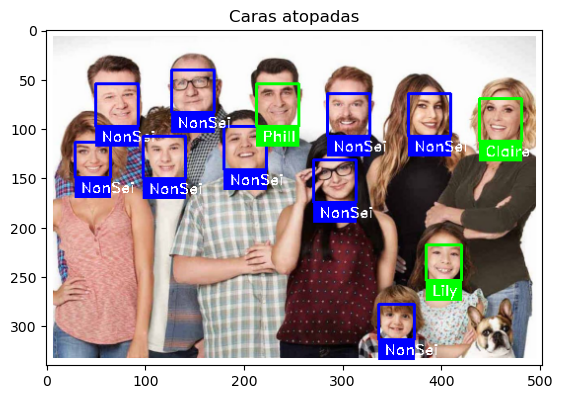

In [13]:
face_names = []

dets = detector(imaxeTodosColor, 1)
tolerancia = 0.1 # distancia máxima que permitimos entre o vector almacenado e o actual
face_descriptors = [list(facerec.compute_face_descriptor(imaxeTodosColor, sp(imaxeTodosColor,d))) for d in dets]
results = collection.query(query_embeddings=face_descriptors, 
                                n_results=1
                                )
carasAtopadas = [posicion for posicion, distancias in enumerate(results['distances']) for distancia in distancias if distancia < tolerancia]
for posCara, d in enumerate(dets):
    nome = results['metadatas'][posCara][0]['nome'] if posCara in carasAtopadas else "NonSei"
    face_names.append(((d.top(), d.right(), d.bottom(), d.left()),nome))

imaxeConMarcas = imaxeTodosColor.copy() 
for (top, right, bottom, left), name in face_names:
    # Scale back up face locations since the frame we detected in was scaled to 1/4 size

    color = (0, 255, 0)
    if name=="NonSei":
        color = (0, 0, 255)
    # Draw a box around the face
    cv2.rectangle(imaxeConMarcas, (left, top), (right, bottom), color, 2)

    # Draw a label with a name below the face
    cv2.rectangle(imaxeConMarcas, (left, bottom + 20), (right, bottom), color, cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(imaxeConMarcas, name, (left + 6, bottom + 15), font, 0.5, (255, 255, 255), 1)

plt.imshow(imaxeConMarcas)
plt.title('Caras atopadas')
plt.show()      